In [8]:
import kagglehub
import os

# Define the target folder
# target_folder = "../data/vegetable-dataset"
# os.makedirs(target_folder, exist_ok=True)

# # Download the dataset to that folder
# path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")

# print("Path to dataset files:", path)


In [9]:
import os ,sys

sys.path.append(os.path.abspath('../'))  # Adjust the path as needed to point to the parent directory containing 'utilis'

In [31]:
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader,random_split ,Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score 
from PIL import Image 
from matplotlib import pyplot as plt
from seaborn import heatmap
import seaborn as sns 
import numpy as np
import pandas as pd
import time 
import random 
import warnings 
import json 
import logging 
import os 
import shutil
import sys 
import torch


In [54]:
# import shutil
# shutil.move(path, target_folder)
import shutil
from sklearn.utils import shuffle
from utils.utils_classification import read_images_classification


# Step 1: Load dataset into numpy
def read_images_classification(path, image_size=(224, 224)):
    X, y = [], []
    labels = os.listdir(path)

    for label in labels:
        label_folder = os.path.join(path, label)
        if os.path.isdir(label_folder):
            for img_file in os.listdir(label_folder):
                if img_file.lower().endswith((".jpg", ".png", ".jpeg")):
                    img_path = os.path.join(label_folder, img_file)
                    try:
                        image = Image.open(img_path).convert("RGB")
                        image = image.resize(image_size)
                        X.append(np.array(image))
                        y.append(label)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")

    X, y = shuffle(np.array(X), np.array(y), random_state=42)
    return X, y


In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
device

device(type='cuda')

In [58]:
train_images, train_labels = read_images_classification("../data/vegetable_dataset/train")
valid_images, valid_labels = read_images_classification("../data/vegetable_dataset/validation")
test_images, test_labels = read_images_classification("../data/vegetable_dataset/test")

In [59]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_labels)
valid_labels = encoder.transform(valid_labels)
test_labels = encoder.transform(test_labels)

array([9, 5, 9, ..., 5, 6, 4])

In [ ]:
# images[0].shape 

(224, 224, 3)

In [61]:
def show_images(images, labels, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        idx = random.randint(0, len(images) - 1)
        ax = plt.subplot(1, num_images, i + 1)
        
        # Check the shape to determine the correct format
        img = images[idx]
        
        if hasattr(img, 'permute'):
            # PyTorch tensor
            if img.shape[0] == 3:  # (C, H, W)
                plt.imshow(img.permute(1, 2, 0))
            else:  # (H, W, C) or (H, C, W)
                if img.shape[1] == 3:  # (H, C, W)
                    plt.imshow(img.permute(0, 2, 1))
                else:  # (H, W, C)
                    plt.imshow(img)
        else:
            # Numpy array
            if img.shape[0] == 3:  # (C, H, W)
                plt.imshow(img.transpose(1, 2, 0))
            else:  # (H, W, C) or (H, C, W)
                if img.shape[1] == 3:  # (H, C, W) - need to transpose to (H, W, C)
                    plt.imshow(img.transpose(0, 2, 1))
                else:  # (H, W, C)
                    plt.imshow(img)
        
        plt.title(labels[idx])
        plt.axis("off")
    plt.show()


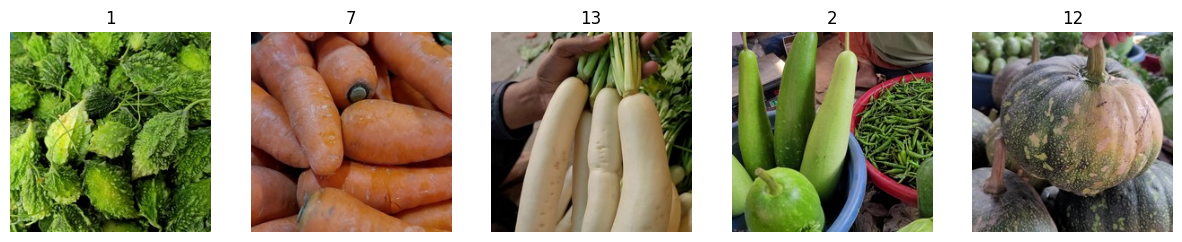

In [64]:
show_images(train_images, train_labels, num_images=5)

In [66]:
# Step 2: Torch dataset wrapper
class VegetableDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  # still numpy
        self.labels = labels  # numeric labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert numpy to PIL for transforms
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [67]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



In [68]:

batch_size = 32
train_dataset = VegetableDataset(train_images, train_labels, transform=transform)
valid_dataset = VegetableDataset(valid_images, valid_labels, transform=transform)
test_dataset = VegetableDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [69]:
### resnet model 
from torchvision import models

## num of classes 

num_classes = len(set(train_labels))
print(f"Number of classes: {num_classes}")

Number of classes: 15


In [70]:
set(train_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

In [71]:
print("Classes:", encoder.classes_)

Classes: ['Bean' 'Bitter_Gourd' 'Bottle_Gourd' 'Brinjal' 'Broccoli' 'Cabbage'
 'Capsicum' 'Carrot' 'Cauliflower' 'Cucumber' 'Papaya' 'Potato' 'Pumpkin'
 'Radish' 'Tomato']


In [72]:

class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

resnet = ResNetModel(num_classes).to(device)


c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [81]:

### without training model prediction 


def test_model(model, test_loader):
    model.eval()
    accuracy_avg = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            f1 = f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='weighted')

            accuracy = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            # print(f"Predicted: {encoder.inverse_transform(preds.cpu().numpy())
            # }, Actual: {encoder.inverse_transform(labels.cpu().numpy())}, F1 Score: {f1}")
        accuracy_avg += accuracy
    return accuracy_avg / len(test_loader)

In [82]:
test_model(resnet, test_loader)


0.0004432624113475177

In [83]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

        val_accuracy = test_model(model, val_loader)
        print(f"Validation Accuracy: {val_accuracy:.4f}")

    return model

In [84]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

train_model(resnet, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 0.3245
Validation Accuracy: 0.0106
Epoch [2/10], Loss: 0.1275
Validation Accuracy: 0.0106
Epoch [3/10], Loss: 0.0905
Validation Accuracy: 0.0106
Epoch [4/10], Loss: 0.0780
Validation Accuracy: 0.0106
Epoch [5/10], Loss: 0.0552
Validation Accuracy: 0.0106
Epoch [6/10], Loss: 0.0760
Validation Accuracy: 0.0102
Epoch [7/10], Loss: 0.0350
Validation Accuracy: 0.0106
Epoch [8/10], Loss: 0.0608
Validation Accuracy: 0.0106
Epoch [9/10], Loss: 0.0387
Validation Accuracy: 0.0106
Epoch [10/10], Loss: 0.0312
Validation Accuracy: 0.0106


ResNetModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [86]:
### save the model 

torch.save(resnet.state_dict(), '../models/resnet_vegetable_classification_128_image.pth')

In [100]:

### let define function to test , score and everything as well sample five images with labels , and save the results
from sklearn.metrics import precision_score, recall_score,classification_report


def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    print(f"F1 Score: {f1}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")
    # Sample five images with their predicted and actual labels
    classification = classification_report(all_labels, all_preds, target_names=encoder.classes_)
    print(classification)
    return f1, accuracy, precision, recall, classification

import matplotlib.pyplot as plt

def test_images(model, test_loader, device, number=5):
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # ensure number <= batch size
            number = min(number, images.size(0))

            for i in range(number):
                img = images[i].cpu().numpy().transpose(1, 2, 0)  # C,H,W -> H,W,C

                # If images were normalized, undo normalization for display
                img = img * 0.5 + 0.5  # Example if normalized to mean=0.5,std=0.5
                img = np.clip(img, 0, 1)

                plt.imshow(img)
                plt.title(f"Predicted: {encoder.inverse_transform([preds[i].item()])[0]}, "
                          f"Actual: {encoder.inverse_transform([labels[i].item()])[0]}")
                plt.axis('off')
                plt.show()
            break  # only one batch




In [101]:
f1, accuracy, precision, recall, classification_report = evaluate_model(resnet, test_loader, device)


F1 Score: 0.9810566472338995, Accuracy: 0.981, Precision: 0.9822728105422122, Recall: 0.981
              precision    recall  f1-score   support

        Bean       0.94      0.98      0.96       200
Bitter_Gourd       1.00      0.99      0.99       200
Bottle_Gourd       1.00      1.00      1.00       200
     Brinjal       0.88      0.98      0.93       200
    Broccoli       0.98      0.98      0.98       200
     Cabbage       0.99      1.00      0.99       200
    Capsicum       0.98      0.99      0.99       200
      Carrot       0.99      0.99      0.99       200
 Cauliflower       1.00      1.00      1.00       200
    Cucumber       1.00      0.91      0.95       200
      Papaya       1.00      0.90      0.95       200
      Potato       0.99      0.99      0.99       200
     Pumpkin       0.99      0.98      0.99       200
      Radish       1.00      1.00      1.00       200
      Tomato       0.99      0.99      0.99       200

    accuracy                           0.9

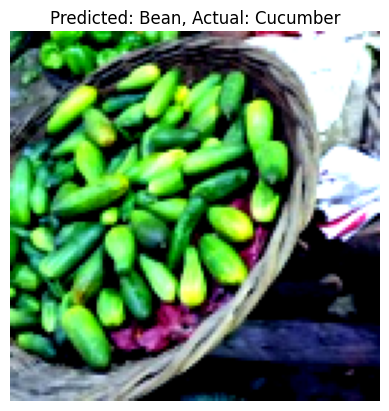

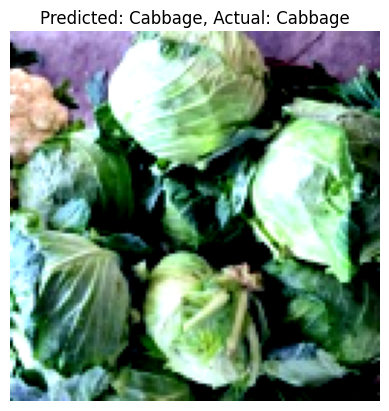

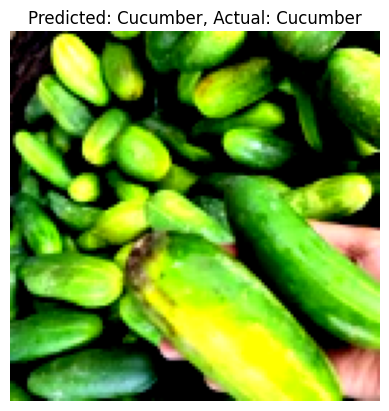

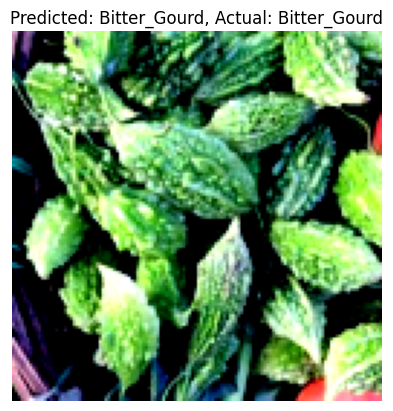

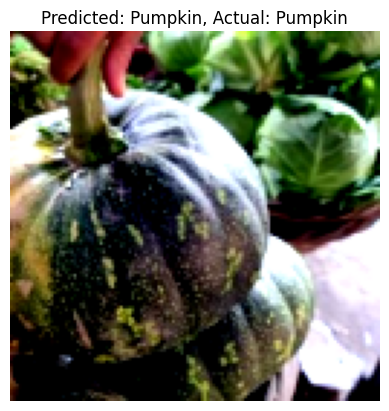

In [102]:
test_images(resnet, test_loader, device, 5)

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, figsize=(8,6), title="Confusion Matrix"):
    """
    y_true: true labels (integers)
    y_pred: predicted labels (integers)
    classes: list of class names in order
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()


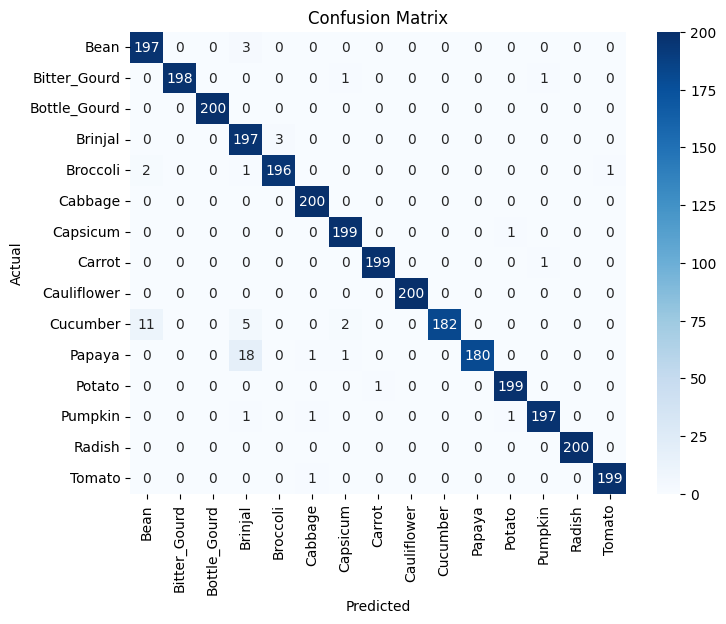

In [104]:
# Collect all predictions and true labels
y_true, y_pred = [], []
resnet.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=encoder.classes_)


In [105]:


efficient_net = models.efficientnet_b0(pretrained=True)
efficient_net.classifier[1] = nn.Linear(efficient_net.classifier[1].in_features, num_classes)
efficient_net = efficient_net.to(device)




c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kavitha padala\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [108]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficient_net.parameters(), lr=1e-4)

train_model(efficient_net, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Epoch [1/10], Loss: 0.4681
Validation Accuracy: 0.0106
Epoch [2/10], Loss: 0.0312
Validation Accuracy: 0.0106
Epoch [3/10], Loss: 0.0145
Validation Accuracy: 0.0106
Epoch [4/10], Loss: 0.0132
Validation Accuracy: 0.0106
Epoch [5/10], Loss: 0.0066
Validation Accuracy: 0.0106
Epoch [6/10], Loss: 0.0048
Validation Accuracy: 0.0106
Epoch [7/10], Loss: 0.0075
Validation Accuracy: 0.0106
Epoch [8/10], Loss: 0.0068
Validation Accuracy: 0.0106
Epoch [9/10], Loss: 0.0046
Validation Accuracy: 0.0106
Epoch [10/10], Loss: 0.0041
Validation Accuracy: 0.0106


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [111]:
f1, accuracy, precision, recall, classification_report = evaluate_model(efficient_net, test_loader, device)

F1 Score: 0.9986658062129027, Accuracy: 0.9986666666666667, Precision: 0.9986765840763181, Recall: 0.9986666666666667


TypeError: 'str' object is not callable

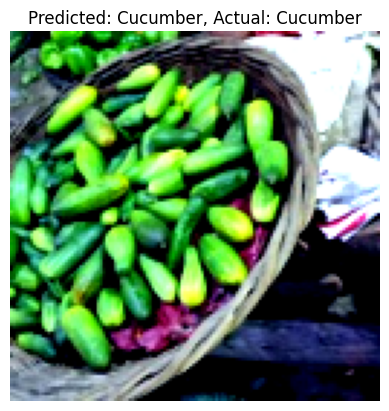

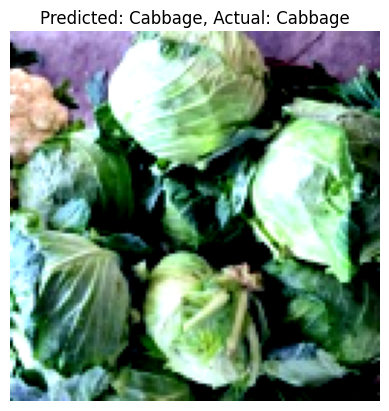

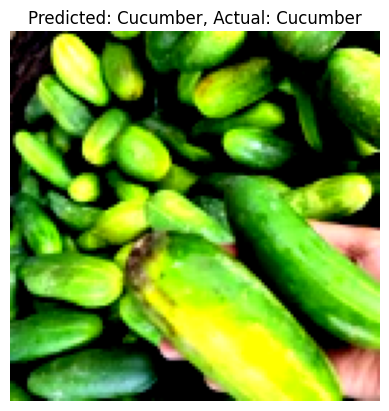

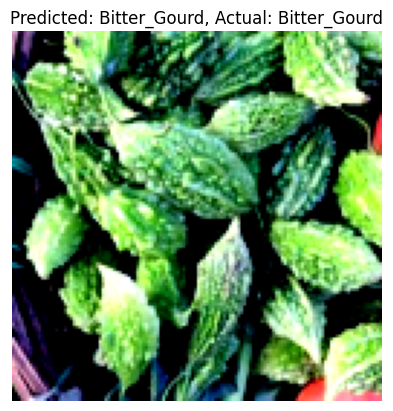

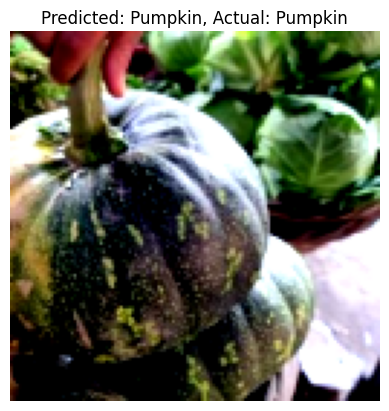

In [112]:
test_images(efficient_net, test_loader, device)

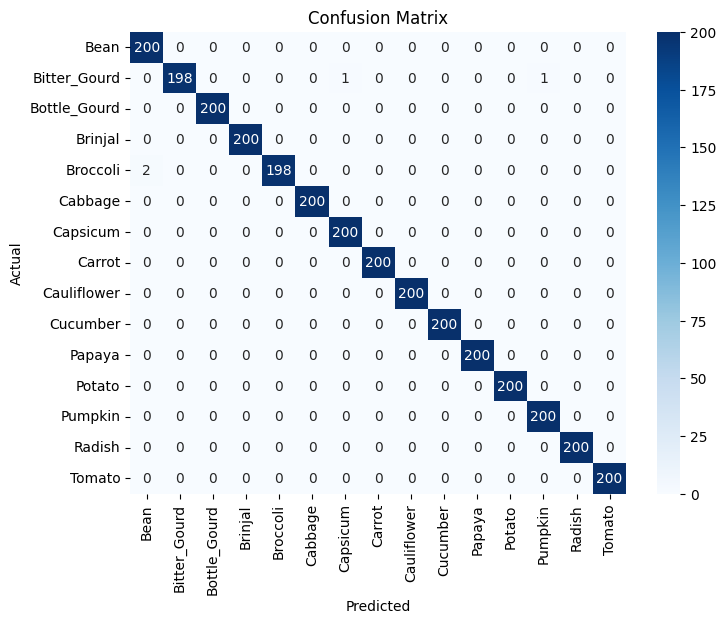

In [113]:
# Collect all predictions and true labels
y_true, y_pred = [], []
efficient_net.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = efficient_net(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=encoder.classes_)


In [114]:
### save the model 

torch.save(efficient_net.state_dict(), '../models/efficient_net_vegetable_classification_128_image.pth')